In [160]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans

In [161]:
products = pd.read_csv('../data/products.csv')
orders = pd.read_csv('../data/orders.csv')
departments = pd.read_csv('../data/departments.csv')
aisles = pd.read_csv('../data/aisles.csv')
train = pd.read_csv('../data/order_products__train.csv')
prior = pd.read_csv('../data/order_products__prior.csv')

### Concat Prior and Train

In [162]:
priorTrain = pd.concat([prior, train])

In [163]:
priorTrain.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### Merge priorTrain with Orders

In [164]:
df = pd.merge(priorTrain, orders, how="left", left_on="order_id", right_on="order_id").drop(['eval_set'], axis=1)

In [165]:
df.sample(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
14581278,1538574,44142,1,0,106576,1,1,14,NaN
15022106,1585109,21903,1,1,185650,73,1,12,3.0
15340472,1618736,13369,9,0,150478,6,6,12,5.0
15255564,1609755,47626,1,0,177444,4,0,12,6.0
25059000,2642922,8518,4,1,117287,23,2,12,5.0
27656791,2916645,34358,9,0,160976,14,5,22,30.0
15800590,1667135,34530,3,0,121544,3,3,11,1.0
29003635,3058911,27845,9,1,184414,69,2,7,7.0
20367983,2148378,42585,4,0,116547,1,6,16,NaN
12243863,1292327,34487,3,1,64865,30,2,12,2.0


In [166]:
df.shape

(33819106, 9)

# EDA

### Summary - Products per Order by User

In [167]:
# Total numbers per order
products_per_order = df.groupby(['user_id','order_id'], as_index=False)[['add_to_cart_order']].max()
# Products per order
products_per_order = products_per_order.groupby(['user_id'], as_index=False)[['add_to_cart_order']].agg(['count', 'sum', 'min', 'max', 'median', 'mean', 'std'])
# Rename columns
products_per_order.columns = ['total_orders','total_products','min_products','max_products','med_products','avg_products','std_products']
products_per_order

,total_orders,total_products,min_products,max_products,med_products,avg_products,std_products
user_id,,,,,,,
1,11,70,4,11,6.0,6.363636,2.110579
2,15,226,5,31,14.0,15.066667,7.055562
3,12,88,5,11,7.0,7.333333,2.103388
4,5,18,2,7,3.0,3.600000,2.073644
5,5,46,5,12,9.0,9.200000,2.683282
...,...,...,...,...,...,...,...
206205,4,51,7,19,12.5,12.750000,6.130525
206206,67,285,1,24,4.0,4.253731,3.230270
206207,16,223,5,25,13.0,13.937500,6.038419


### Summary - Reordered Products per Orders by Users

In [168]:
# Total items per order
items_per_order = df.groupby(['user_id','order_id'], as_index=False)[['add_to_cart_order']].max()
# Total items reordered per order
reorders_per_order = df.groupby(['user_id','order_id'], as_index=False)[['reordered']].sum()
# Combine items/order and reoredered items/order
reorders = pd.merge(items_per_order, reorders_per_order, how="left")
# Percent of items are reordered
reorders['percent_reordered'] = reorders['reordered']/reorders['add_to_cart_order']
# Summary stats
reorders = reorders.groupby(['user_id'], as_index=False)[['percent_reordered']].agg(['max', 'median', 'mean', 'std'])
# Rename columns
reorders.columns=['max_reordered','med_reordered','avg_reordered','std_reordered']
reorders

,max_reordered,med_reordered,avg_reordered,std_reordered
user_id,,,,
1,1.000000,0.666667,0.724311,0.307419
2,0.888889,0.562500,0.443903,0.304708
3,1.000000,0.763889,0.658817,0.333725
4,0.142857,0.000000,0.028571,0.063888
5,0.666667,0.444444,0.391111,0.242212
...,...,...,...,...
206205,0.857143,0.282895,0.355733,0.360894
206206,1.000000,0.500000,0.570676,0.312977
206207,1.000000,0.645833,0.637144,0.310794


### Summary - Days Between Orders by User

In [169]:
# Days between orders
days = df.groupby(['user_id'], as_index=False)[['days_since_prior_order']].agg(['count', 'min', 'max', 'median', 'mean', 'std'])
# Rename columns
days.columns=['total_days','min_days','max_days','med_days','avg_days','std_days']
days

,total_days,min_days,max_days,med_days,avg_days,std_days
user_id,,,,,,
1,65,0.0,30.0,19.0,19.200000,8.791331
2,213,3.0,30.0,13.0,18.009390,9.778196
3,78,7.0,21.0,10.0,11.487179,4.869048
4,14,0.0,21.0,20.0,15.357143,8.580901
5,35,6.0,19.0,11.0,12.314286,5.251170
...,...,...,...,...,...,...
206205,34,10.0,30.0,10.0,14.705882,8.611231
206206,281,0.0,15.0,3.0,4.042705,3.453511
206207,199,1.0,30.0,16.0,14.879397,11.293850


### Summary - Percent of Products by Day

In [170]:
# Recalled
items_per_order = df.groupby(['user_id','order_id'], as_index=False)[['add_to_cart_order']].max()
items_per_order

# Dummify day of the week
dummy_days = pd.get_dummies(df['order_dow'])
dummy_days.columns = ['sat','sun','mon','tues','wed','thur','fri']

# Merge dummy_days with df on index
dow = pd.merge(df, dummy_days, how='left', left_index=True, right_index=True)

# Products purchased per day
dow2 = dow.groupby(['order_id'],as_index=False)[['sat','sun','mon','tues','wed','thur','fri']].agg(['sum'])

# Products purchased by day and total products purchased by order
dow3 = pd.merge(items_per_order, dow2, how='left', left_on='order_id', right_on='order_id')
dow3.columns = ['user_id','order_id','total_products','sat','sun','mon','tues','wed','thur','fri']

# Percent of products purchased by day
dow4 = dow3.groupby(['user_id'], as_index=False)[['total_products','sat','sun','mon','tues','wed','thur','fri']].sum()
dow4['per_prod_sat'] = dow4['sat']/dow4['total_products']
dow4['per_prod_sun'] = dow4['sun']/dow4['total_products']
dow4['per_prod_mon'] = dow4['mon']/dow4['total_products']
dow4['per_prod_tues'] = dow4['tues']/dow4['total_products']
dow4['per_prod_wed'] = dow4['wed']/dow4['total_products']
dow4['per_prod_thur'] = dow4['thur']/dow4['total_products']
dow4['per_prod_fri'] = dow4['fri']/dow4['total_products']
percent_products_dow = dow4[['user_id','per_prod_sat','per_prod_sun','per_prod_mon','per_prod_tues','per_prod_wed','per_prod_thur','per_prod_fri']]
percent_products_dow

# Percent of products purchased during different groupings of days
percent_products_dow['per_prod_weekend'] = percent_products_dow['per_prod_sat'] + percent_products_dow['per_prod_sun']
percent_products_dow['per_prod_weekday'] = 1 - percent_products_dow['per_prod_weekend']
percent_products_dow['per_prod_early_week'] = percent_products_dow['per_prod_mon'] + percent_products_dow['per_prod_tues'] + percent_products_dow['per_prod_wed']
percent_products_dow['per_prod_late_week'] = percent_products_dow['per_prod_thur'] + percent_products_dow['per_prod_fri']
percent_products_dow

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

,user_id,per_prod_sat,per_prod_sun,per_prod_mon,per_prod_tues,per_prod_wed,per_prod_thur,per_prod_fri,per_prod_weekend,per_prod_weekday,per_prod_early_week,per_prod_late_week
0,1,0.000000,0.242857,0.128571,0.157143,0.471429,0.000000,0.000000,0.242857,0.757143,0.757143,0.000000
1,2,0.000000,0.420354,0.384956,0.128319,0.039823,0.026549,0.000000,0.420354,0.579646,0.553097,0.026549
2,3,0.522727,0.181818,0.056818,0.238636,0.000000,0.000000,0.000000,0.704545,0.295455,0.295455,0.000000
3,4,0.000000,0.000000,0.000000,0.000000,0.500000,0.277778,0.222222,0.000000,1.000000,0.500000,0.500000
4,5,0.391304,0.260870,0.000000,0.347826,0.000000,0.000000,0.000000,0.652174,0.347826,0.347826,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
206204,206205,0.000000,0.372549,0.156863,0.000000,0.333333,0.137255,0.000000,0.372549,0.627451,0.490196,0.137255
206205,206206,0.238596,0.189474,0.115789,0.157895,0.168421,0.035088,0.094737,0.428070,0.571930,0.442105,0.129825
206206,206207,0.125561,0.192825,0.161435,0.183857,0.026906,0.134529,0.174888,0.318386,0.681614,0.372197,0.309417
206207,206208,0.081241,0.177253,0.258493,0.152142,0.129985,0.115214,0.085672,0.258493,0.741507,0.540620,0.200886


### Summary - Total Products by Day

In [171]:
# Total products purchased by day
dow5 = dow3.groupby(['user_id'], as_index=False)[['sat','sun','mon','tues','wed','thur','fri']].sum()
dow5.columns = ['user_id','total_prod_sat','total_prod_sun','total_prod_mon','total_prod_tues','total_prod_wed','total_prod_thur','total_prod_fri']
total_products_dow = dow5

# Total products purchased during different groupings of days
total_products_dow['total_prod_weekend'] = total_products_dow['total_prod_sat'] + total_products_dow['total_prod_sun']
total_products_dow['total_prod_weekday'] = total_products_dow['total_prod_mon'] + total_products_dow['total_prod_tues'] + total_products_dow['total_prod_wed'] + total_products_dow['total_prod_thur'] + total_products_dow['total_prod_fri']
total_products_dow['total_prod_late_week'] = total_products_dow['total_prod_thur'] + total_products_dow['total_prod_fri']
total_products_dow['total_prod_early_week'] = total_products_dow['total_prod_mon'] + total_products_dow['total_prod_tues'] + total_products_dow['total_prod_wed']
total_products_dow['total_prod_late_week'] = total_products_dow['total_prod_thur'] + total_products_dow['total_prod_fri']
total_products_dow

,user_id,total_prod_sat,total_prod_sun,total_prod_mon,total_prod_tues,total_prod_wed,total_prod_thur,total_prod_fri,total_prod_weekend,total_prod_weekday,total_prod_late_week,total_prod_early_week
0,1,0.0,17.0,9.0,11.0,33.0,0.0,0.0,17.0,53.0,0.0,53.0
1,2,0.0,95.0,87.0,29.0,9.0,6.0,0.0,95.0,131.0,6.0,125.0
2,3,46.0,16.0,5.0,21.0,0.0,0.0,0.0,62.0,26.0,0.0,26.0
3,4,0.0,0.0,0.0,0.0,9.0,5.0,4.0,0.0,18.0,9.0,9.0
4,5,18.0,12.0,0.0,16.0,0.0,0.0,0.0,30.0,16.0,0.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...
206204,206205,0.0,19.0,8.0,0.0,17.0,7.0,0.0,19.0,32.0,7.0,25.0
206205,206206,68.0,54.0,33.0,45.0,48.0,10.0,27.0,122.0,163.0,37.0,126.0
206206,206207,28.0,43.0,36.0,41.0,6.0,30.0,39.0,71.0,152.0,69.0,83.0
206207,206208,55.0,120.0,175.0,103.0,88.0,78.0,58.0,175.0,502.0,136.0,366.0


### Summary - Percent of Products by Hour

In [172]:
# Dummify hours of the day
dummy_hours = pd.get_dummies(df['order_hour_of_day'])

# Merge dummy_hours with df index
hod = pd.merge(df, dummy_hours, how='left', left_index=True, right_index=True)

# Products purchased by hour
hod2 = hod.groupby(['order_id'],as_index=False)[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]].agg(['sum'])

# Products purchased by hour and total products purchased by order
hod3 = pd.merge(items_per_order, hod2, how='left', left_on='order_id', right_on='order_id')
hod3.columns = ['user_id','order_id','total_products','0','1','2','3','4','5','6','7','8','9','10',\
                '11','12','13','14','15','16','17','18','19','20','21','22','23']

# Percent of products purchased by hour
hod4 = hod3.groupby(['user_id'], as_index=False)[['total_products','0','1','2','3','4','5','6','7','8','9','10',\
                '11','12','13','14','15','16','17','18','19','20','21','22','23']].sum()
hod4['per_prod_0'] = hod4['0']/hod4['total_products']
hod4['per_prod_1'] = hod4['1']/hod4['total_products']
hod4['per_prod_2'] = hod4['2']/hod4['total_products']
hod4['per_prod_3'] = hod4['3']/hod4['total_products']
hod4['per_prod_4'] = hod4['4']/hod4['total_products']
hod4['per_prod_5'] = hod4['5']/hod4['total_products']
hod4['per_prod_6'] = hod4['6']/hod4['total_products']
hod4['per_prod_7'] = hod4['7']/hod4['total_products']
hod4['per_prod_8'] = hod4['8']/hod4['total_products']
hod4['per_prod_9'] = hod4['9']/hod4['total_products']
hod4['per_prod_10'] = hod4['10']/hod4['total_products']
hod4['per_prod_11'] = hod4['11']/hod4['total_products']
hod4['per_prod_12'] = hod4['12']/hod4['total_products']
hod4['per_prod_13'] = hod4['13']/hod4['total_products']
hod4['per_prod_14'] = hod4['14']/hod4['total_products']
hod4['per_prod_15'] = hod4['15']/hod4['total_products']
hod4['per_prod_16'] = hod4['16']/hod4['total_products']
hod4['per_prod_17'] = hod4['17']/hod4['total_products']
hod4['per_prod_18'] = hod4['18']/hod4['total_products']
hod4['per_prod_19'] = hod4['19']/hod4['total_products']
hod4['per_prod_20'] = hod4['20']/hod4['total_products']
hod4['per_prod_21'] = hod4['21']/hod4['total_products']
hod4['per_prod_22'] = hod4['22']/hod4['total_products']
hod4['per_prod_23'] = hod4['23']/hod4['total_products']
hod4 = hod4[['per_prod_0','per_prod_1','per_prod_2','per_prod_3','per_prod_4',\
            'per_prod_5','per_prod_6','per_prod_7','per_prod_8','per_prod_9','per_prod_10',\
            'per_prod_11','per_prod_12','per_prod_13','per_prod_14','per_prod_15','per_prod_16',\
            'per_prod_17','per_prod_18','per_prod_19','per_prod_20','per_prod_21','per_prod_22','per_prod_23']]

# Percent of products purchased during different groupings of hours
hod4['per_prod_morning'] = hod4['per_prod_6'] + hod4['per_prod_7'] + hod4['per_prod_8'] + hod4['per_prod_9'] + hod4['per_prod_10']
hod4['per_prod_lunch'] = hod4['per_prod_11'] + hod4['per_prod_12'] + hod4['per_prod_13']
hod4['per_prod_afternoon'] = hod4['per_prod_14'] + hod4['per_prod_15'] + hod4['per_prod_16']
hod4['per_prod_evening'] = hod4['per_prod_17'] + hod4['per_prod_18'] + hod4['per_prod_19'] + hod4['per_prod_20'] + hod4['per_prod_21']
hod4['per_prod_afterhours'] = hod4['per_prod_22'] + hod4['per_prod_23'] + hod4['per_prod_0'] + hod4['per_prod_1'] + hod4['per_prod_2'] + hod4['per_prod_3'] + hod4['per_prod_4'] + hod4['per_prod_5']                                                                                                              
percent_products_hod = hod4
percent_products_hod

,per_prod_0,per_prod_1,per_prod_2,per_prod_3,per_prod_4,per_prod_5,per_prod_6,per_prod_7,per_prod_8,per_prod_9,...,per_prod_19,per_prod_20,per_prod_21,per_prod_22,per_prod_23,per_prod_morning,per_prod_lunch,per_prod_afternoon,per_prod_evening,per_prod_afterhours
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.214286,0.357143,0.071429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.642857,0.071429,0.285714,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.292035,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.535398,0.393805,0.070796,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.102273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.568182,0.431818,0.000000
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.611111,0.388889,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.434783,0.195652,0.369565,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.666667,0.000000,0.000000
206205,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.010526,...,0.147368,0.059649,0.000000,0.000000,0.000000,0.010526,0.084211,0.259649,0.645614,0.000000
206206,0.0,0.0,0.0,0.0,0.035874,0.0,0.0,0.112108,0.000000,0.000000,...,0.107623,0.112108,0.022422,0.000000,0.000000,0.255605,0.273543,0.192825,0.242152,0.035874
206207,0.0,0.0,0.0,0.0,0.033973,0.0,0.0,0.000000,0.017725,0.082718,...,0.038405,0.013294,0.000000,0.048744,0.005908,0.162482,0.155096,0.468242,0.125554,0.088626


### Summary - Total Products by Hour

In [175]:
# Total products by hour
hod5 = hod3.groupby(['user_id'], as_index=False)[['0','1','2','3','4','5','6','7','8','9','10',\
                '11','12','13','14','15','16','17','18','19','20','21','22','23']].sum()
hod5.columns = ['user_id','total_prod_0','total_prod_1','total_prod_2','total_prod_3','total_prod_4','total_prod_5',\
                'total_prod_6','total_prod_7','total_prod_8','total_prod_9','total_prod_10','total_prod_11',\
                'total_prod_12','total_prod_13','total_prod_14','total_prod_15','total_prod_16','total_prod_17',\
                'total_prod_18','total_prod_19','total_prod_20','total_prod_21','total_prod_22','total_prod_23']

# Total products purchased during different groupings of hours
hod5['total_prod_morning'] = hod5['total_prod_6'] + hod5['total_prod_7'] + hod5['total_prod_8'] + hod5['total_prod_9'] + hod5['total_prod_10']
hod5['total_prod_lunch'] = hod5['total_prod_11'] + hod5['total_prod_12'] + hod5['total_prod_13']
hod5['total_prod_afternoon'] = hod5['total_prod_14'] + hod5['total_prod_15'] + hod5['total_prod_16']
hod5['total_prod_evening'] = hod5['total_prod_17'] + hod5['total_prod_18'] + hod5['total_prod_19'] + hod5['total_prod_20'] + hod5['total_prod_21']
hod5['total_prod_afterhours'] = hod5['total_prod_22'] + hod5['total_prod_23'] + hod5['total_prod_0'] + hod5['total_prod_1'] + hod5['total_prod_2'] + hod5['total_prod_3'] + hod5['total_prod_4'] + hod5['total_prod_5']

total_products_hod = hod5.drop(['user_id'], axis=1)
total_products_hod

,total_prod_0,total_prod_1,total_prod_2,total_prod_3,total_prod_4,total_prod_5,total_prod_6,total_prod_7,total_prod_8,total_prod_9,...,total_prod_19,total_prod_20,total_prod_21,total_prod_22,total_prod_23,total_prod_morning,total_prod_lunch,total_prod_afternoon,total_prod_evening,total_prod_afterhours
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,25.0,5.0,...,0.0,0.0,0.0,0.0,0.0,45.0,5.0,20.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,...,0.0,0.0,0.0,0.0,0.0,121.0,89.0,16.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,38.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,7.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,20.0,9.0,17.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,17.0,34.0,0.0,0.0
206205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,42.0,17.0,0.0,0.0,0.0,3.0,24.0,74.0,184.0,0.0
206206,0.0,0.0,0.0,0.0,8.0,0.0,0.0,25.0,0.0,0.0,...,24.0,25.0,5.0,0.0,0.0,57.0,61.0,43.0,54.0,8.0
206207,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,12.0,56.0,...,26.0,9.0,0.0,33.0,4.0,110.0,105.0,317.0,85.0,60.0


### Merge Summaries

In [180]:
user_summary = pd.merge(products_per_order, reorders, how='left', left_index=True, right_index=True)
user_summary = pd.merge(user_summary, days, how='left', left_index=True, right_index=True)
user_summary = pd.merge(user_summary, total_products_dow, how='left', left_index=True, right_index=True)
user_summary = pd.merge(user_summary, percent_products_dow, how='left', left_index=True, right_index=True)
user_summary = pd.merge(user_summary, total_products_hod, how='left', left_index=True, right_index=True)
user_summary = pd.merge(user_summary, percent_products_hod, how='left', left_index=True, right_index=True)
user_summary.fillna(0, inplace=True)
user_summary = user_summary.drop(['user_id_x','user_id_y'], axis=1)
user_summary

,total_orders,total_products,min_products,max_products,med_products,avg_products,std_products,max_reordered,med_reordered,avg_reordered,...,per_prod_19,per_prod_20,per_prod_21,per_prod_22,per_prod_23,per_prod_morning,per_prod_lunch,per_prod_afternoon,per_prod_evening,per_prod_afterhours
user_id,,,,,,,,,,,,,,,,,,,,,
1,11,70,4,11,6.0,6.363636,2.110579,1.000000,0.666667,0.724311,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.535398,0.393805,0.070796,0.000000,0.000000
2,15,226,5,31,14.0,15.066667,7.055562,0.888889,0.562500,0.443903,...,0.102273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.568182,0.431818,0.000000
3,12,88,5,11,7.0,7.333333,2.103388,1.000000,0.763889,0.658817,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.611111,0.388889,0.000000,0.000000
4,5,18,2,7,3.0,3.600000,2.073644,0.142857,0.000000,0.028571,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.434783,0.195652,0.369565,0.000000
5,5,46,5,12,9.0,9.200000,2.683282,0.666667,0.444444,0.391111,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,4,51,7,19,12.5,12.750000,6.130525,0.857143,0.282895,0.355733,...,0.147368,0.059649,0.000000,0.000000,0.000000,0.010526,0.084211,0.259649,0.645614,0.000000
206206,67,285,1,24,4.0,4.253731,3.230270,1.000000,0.500000,0.570676,...,0.107623,0.112108,0.022422,0.000000,0.000000,0.255605,0.273543,0.192825,0.242152,0.035874
206207,16,223,5,25,13.0,13.937500,6.038419,1.000000,0.645833,0.637144,...,0.038405,0.013294,0.000000,0.048744,0.005908,0.162482,0.155096,0.468242,0.125554,0.088626


In [181]:
user_summary.columns.to_list()

['total_orders',
 'total_products',
 'min_products',
 'max_products',
 'med_products',
 'avg_products',
 'std_products',
 'max_reordered',
 'med_reordered',
 'avg_reordered',
 'std_reordered',
 'total_days',
 'min_days',
 'max_days',
 'med_days',
 'avg_days',
 'std_days',
 'total_prod_sat',
 'total_prod_sun',
 'total_prod_mon',
 'total_prod_tues',
 'total_prod_wed',
 'total_prod_thur',
 'total_prod_fri',
 'total_prod_weekend',
 'total_prod_weekday',
 'total_prod_late_week',
 'total_prod_early_week',
 'per_prod_sat',
 'per_prod_sun',
 'per_prod_mon',
 'per_prod_tues',
 'per_prod_wed',
 'per_prod_thur',
 'per_prod_fri',
 'per_prod_weekend',
 'per_prod_weekday',
 'per_prod_early_week',
 'per_prod_late_week',
 'total_prod_0',
 'total_prod_1',
 'total_prod_2',
 'total_prod_3',
 'total_prod_4',
 'total_prod_5',
 'total_prod_6',
 'total_prod_7',
 'total_prod_8',
 'total_prod_9',
 'total_prod_10',
 'total_prod_11',
 'total_prod_12',
 'total_prod_13',
 'total_prod_14',
 'total_prod_15',
 'total

In [182]:
user_summary.to_csv('../data/user_summary.csv') 

### Correlations

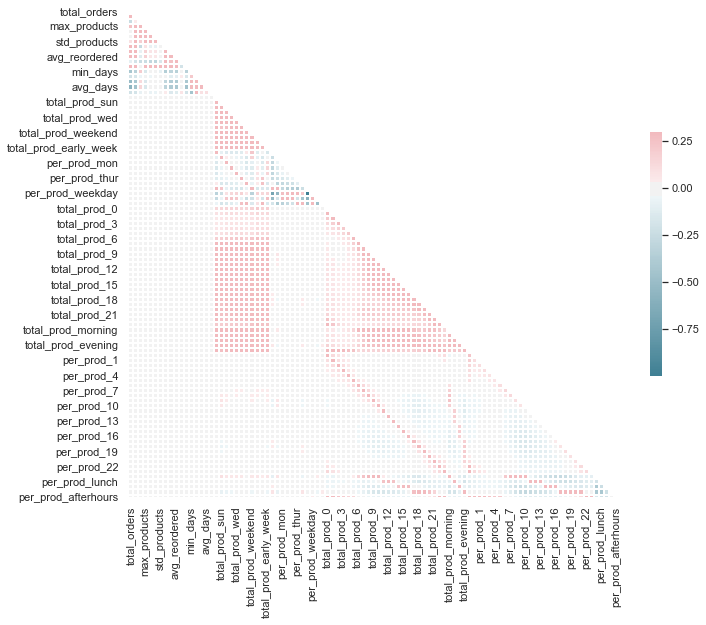

In [183]:
# Check Correlations Between Variables
from string import ascii_letters
sns.set(style="white")

# Compute the correlation matrix
corr = user_summary.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.5})

### Exploring DOW

#### Total Products

Text(0, 0.5, 'Avg Products Purchased')

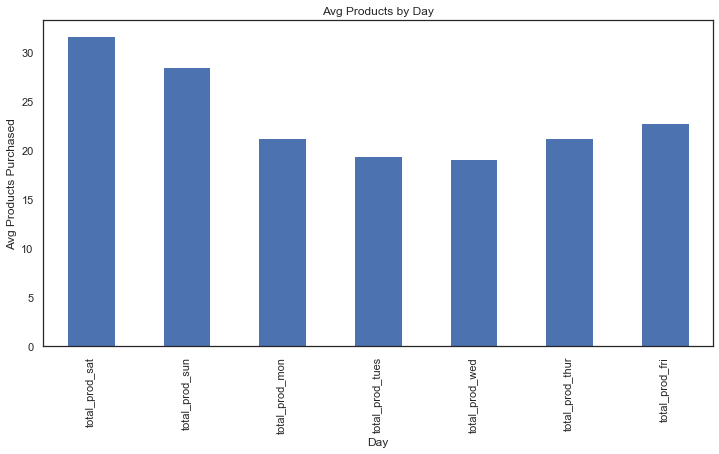

In [134]:
plt.figure(figsize=(12,6))
total_products_dow.drop(['user_id'], axis=1).mean().plot.bar()
plt.title('Avg Products by Day')
plt.xlabel('Day')
plt.ylabel('Avg Products Purchased')

Text(0, 0.5, 'Products Purchased')

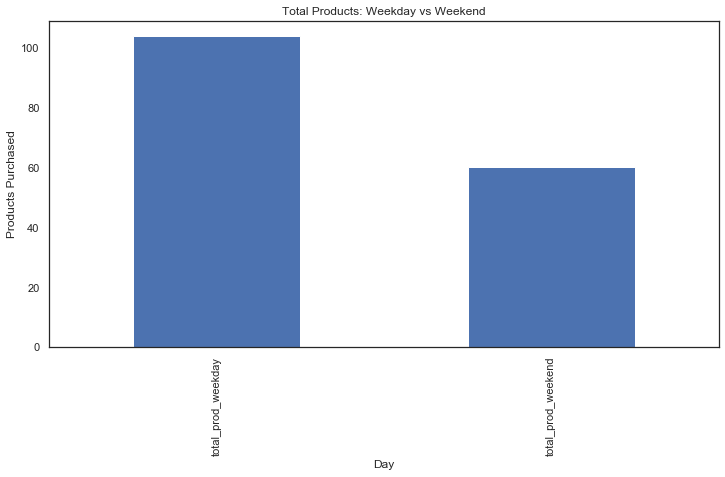

In [187]:
plt.figure(figsize=(12,6))
total_products_dow.drop(['user_id'], axis=1)[['total_prod_weekday','total_prod_weekend']].mean().plot.bar()
plt.title('Total Products: Weekday vs Weekend')
plt.xlabel('Day')
plt.ylabel('Products Purchased')

Text(0, 0.5, 'Products Purchased')

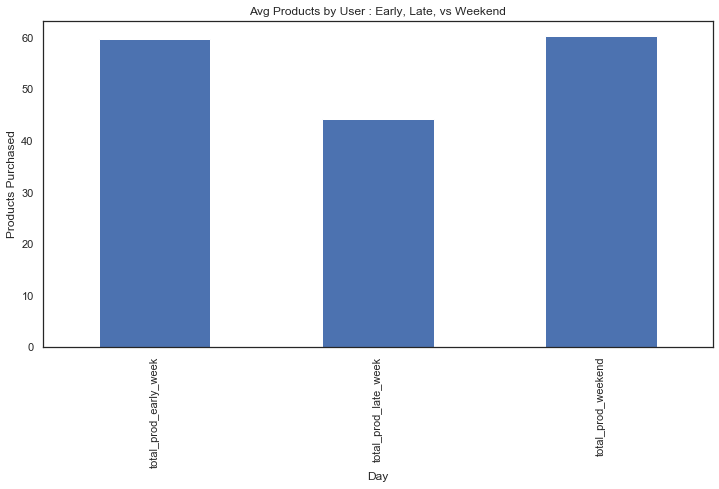

In [198]:
plt.figure(figsize=(12,6))
total_products_dow.drop(['user_id'], axis=1)[['total_prod_early_week','total_prod_late_week','total_prod_weekend']].mean().plot.bar()
plt.title('Avg Products by User: Early, Late, vs Weekend')
plt.xlabel('Day')
plt.ylabel('Products Purchased')

#### Percent of Products

Text(0, 0.5, 'Percentage of Products Purchased')

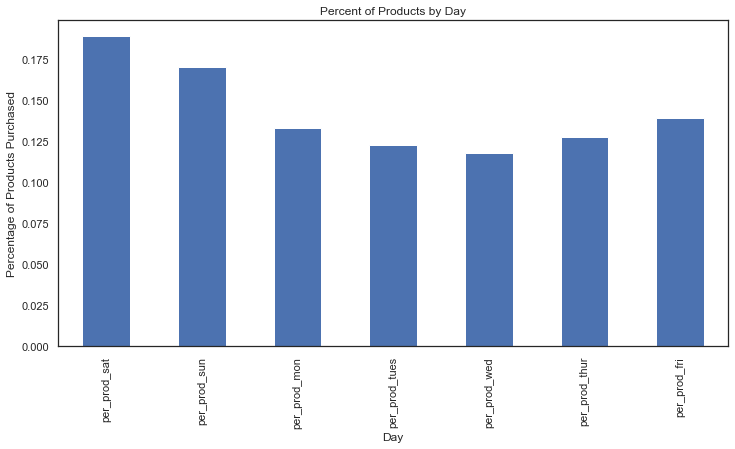

In [131]:
plt.figure(figsize=(12,6))
percent_products_dow.drop(['user_id'], axis=1).mean().plot.bar()
plt.title('Avg Percent of Products by Day')
plt.xlabel('Day')
plt.ylabel('Avg Percentage of Products Purchased')

Text(0, 0.5, 'Avg Percentage of Products Purchased')

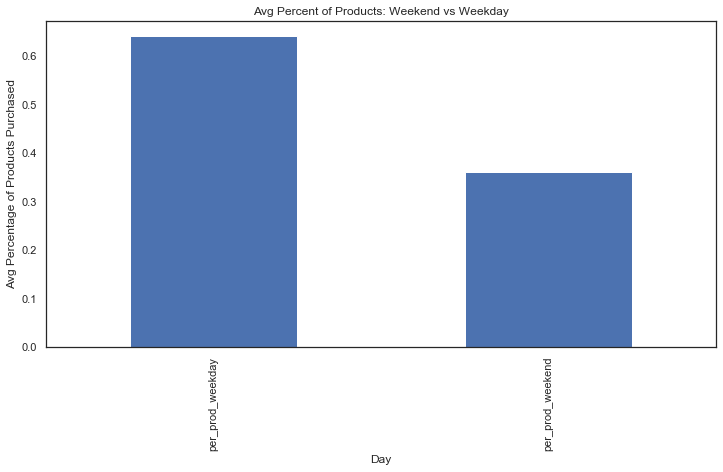

In [184]:
plt.figure(figsize=(12,6))
percent_products_dow.drop(['user_id'], axis=1)[['per_prod_weekday','per_prod_weekend']].mean().plot.bar()
plt.title('Avg Percent of Products: Weekday vs Weekend')
plt.xlabel('Day')
plt.ylabel('Avg Percentage of Products Purchased')

Text(0, 0.5, 'Avg Percentage of Products Purchased')

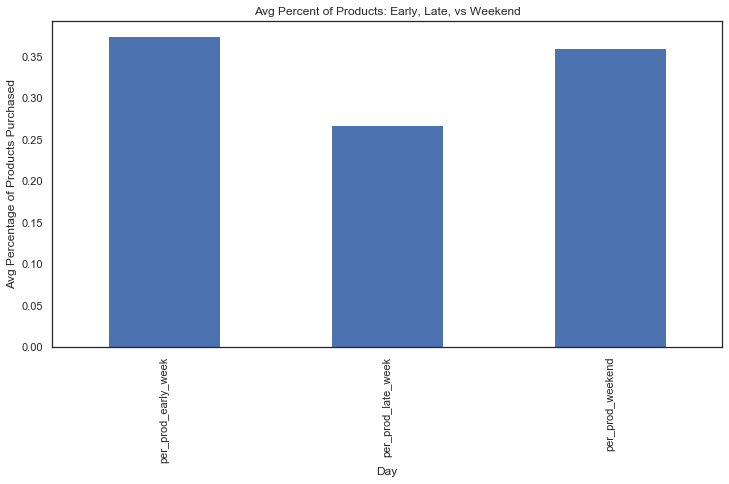

In [185]:
plt.figure(figsize=(12,6))
percent_products_dow.drop(['user_id'], axis=1)[['per_prod_early_week','per_prod_late_week','per_prod_weekend']].mean().plot.bar()
plt.title('Avg Percent of Products: Early, Late, vs Weekend')
plt.xlabel('Day')
plt.ylabel('Avg Percentage of Products Purchased')

### Exploring HOD

#### Total Products HOD

Text(0, 0.5, 'Avg of Products Purchased')

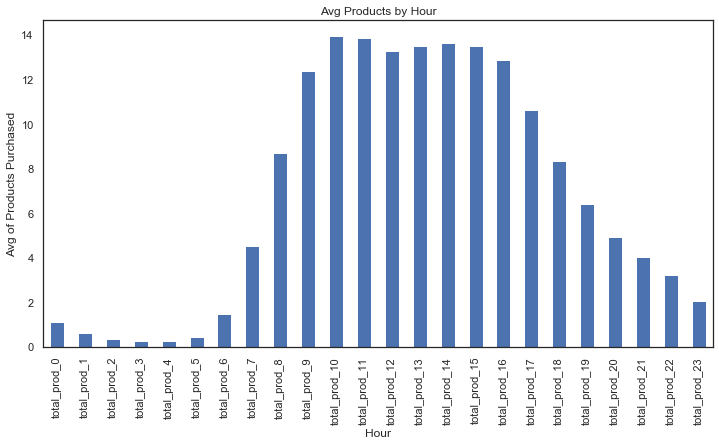

In [138]:
plt.figure(figsize=(12,6))
total_products_hod.drop(['user_id'], axis=1).mean().plot.bar()
plt.title('Avg Products by Hour')
plt.xlabel('Hour')
plt.ylabel('Avg of Products Purchased')

Text(0, 0.5, 'Avg of Products Purchased')

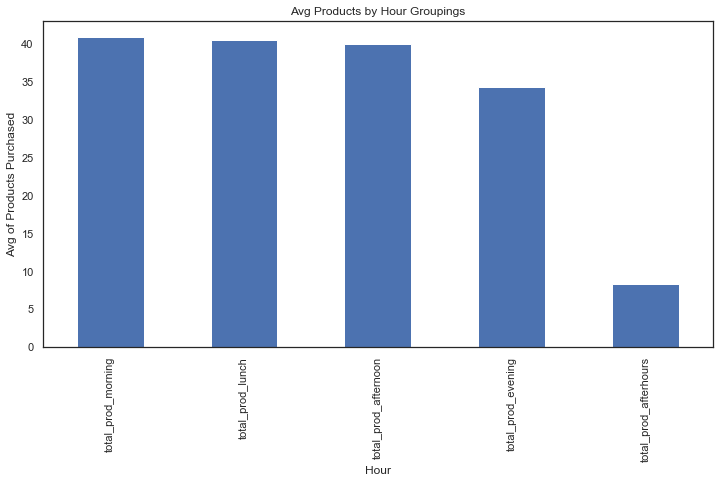

In [193]:
plt.figure(figsize=(12,6))
total_products_hod[['total_prod_morning', 'total_prod_lunch', 'total_prod_afternoon',\
                    'total_prod_evening', 'total_prod_afterhours']].mean().plot.bar()
plt.title('Avg Products by Hour Groupings')
plt.xlabel('Hour')
plt.ylabel('Avg of Products Purchased')

#### Percent Products HOD

Text(0, 0.5, 'Avg Percentage of Products Purchased')

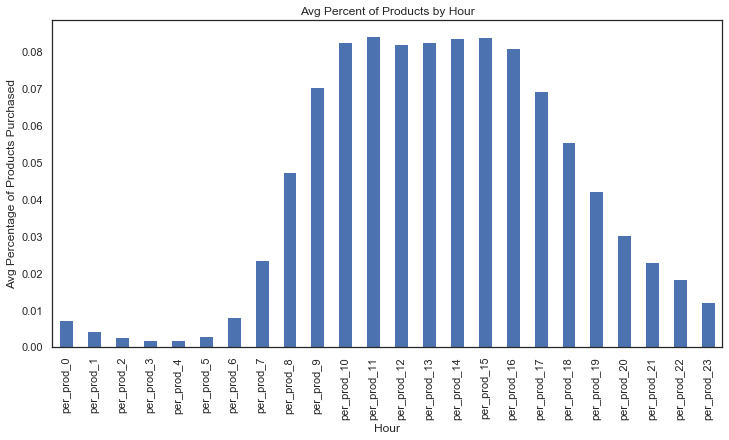

In [135]:
plt.figure(figsize=(12,6))
percent_products_hod.drop(['user_id'], axis=1).mean().plot.bar()
plt.title('Avg Percent of Products by Hour')
plt.xlabel('Hour')
plt.ylabel('Avg Percentage of Products Purchased')

Text(0, 0.5, 'Percent of Products Purchased')

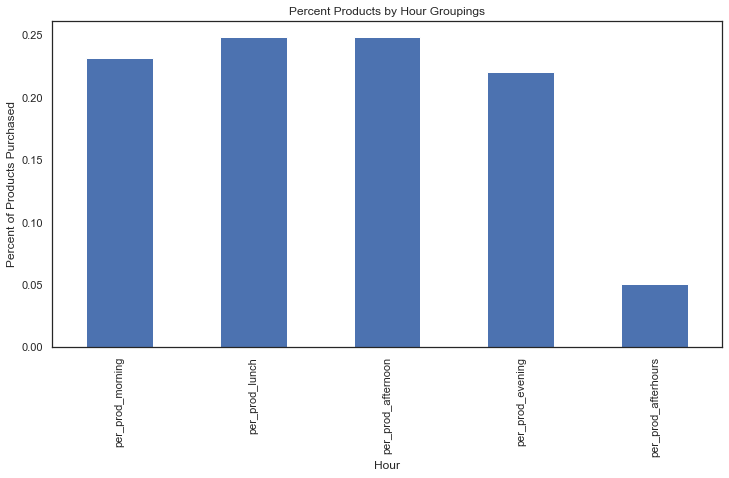

In [195]:
plt.figure(figsize=(12,6))
percent_products_hod[['per_prod_morning', 'per_prod_lunch', 'per_prod_afternoon',\
                    'per_prod_evening', 'per_prod_afterhours']].mean().plot.bar()
plt.title('Percent Products by Hour Groupings')
plt.xlabel('Hour')
plt.ylabel('Percent of Products Purchased')

### Outliers

In [212]:
# def index_of_outliers(user_summary, series_name, std_threshold):
#     mask = np.abs(user_summary[series_name] - user_summary[series_name].mean()) >= (std_threshold*user_summary[series_name].std())
#     return user_summary.index[mask].tolist()

In [230]:
# def remove_rows_from_df(user_summary, list_of_rows_to_drop, printDetails = False):
#     user_summary_rows_removed = user_summary.drop(user_summary.index[list_of_rows_to_drop])
#     if printDetails:
#         print(len(set(list_of_rows_to_drop)),"observations (rows) dropped from dataframe")
#         print("Dimensions of new dataframe:", user_summary_rows_removed.shape)
#     return user_summary_rows_removed

# # Returns a new dataframe without outliers
# def remove_rows_with_outliers(user_summary, list_of_column_names, std_threshold, printDetails = False):
#     set_of_indices_of_all_outliers = set()
#     for column_name in list_of_column_names:
#         set_of_indices_of_outliers = indices_of_outliers(user_summary, column_name, std_threshold, printDetails)
#         if printDetails:
#             print("")
#         set_of_indices_of_all_outliers = set_of_indices_of_all_outliers.union(set_of_indices_of_outliers)
#     list_of_indices_to_drop = list(set_of_indices_of_all_outliers)
#     if printDetails:
#         print("Dropping outliers based on", std_threshold, "standard deviation criteria...")
#     user_summary_no_outliers = remove_rows_from_df(df, list_of_indices_to_drop, printDetails)
#     return user_summary_no_outliers

In [239]:
list_of_column_names = user_summary.columns.to_list()

### Helper Function to Explore user_summary

In [209]:
def explore(user_summary, series_name):
    print("Quantile analysis:")
    print(user_summary[series_name].describe())
    print("")
    lis = index_of_outliers(user_summary, series_name, std_threshold = 4)
    print("Number of outliers:" + str(len(lis)))
    user_summary.boxplot(column=[series_name], figsize=(9,6))
    plt.show()
    print("")
    user_summary[series_name].hist(bins=50, figsize=(9,6))
    print("")
    user_summary.plot.scatter(x=series_name, y ='total_orders', figsize=(9,6))

#### total_orders

Quantile analysis:
count    206209.000000
mean         16.226658
std          16.662238
min           3.000000
25%           6.000000
50%          10.000000
75%          20.000000
max         100.000000
Name: total_orders, dtype: float64

Number of outliers:2564


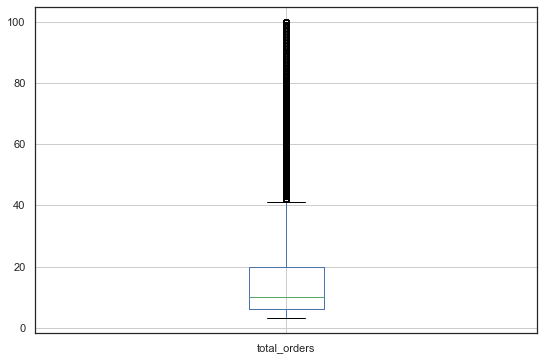

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


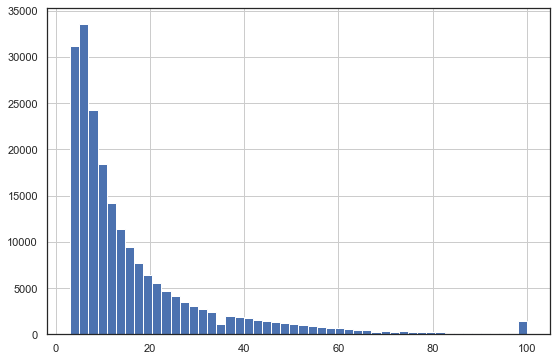

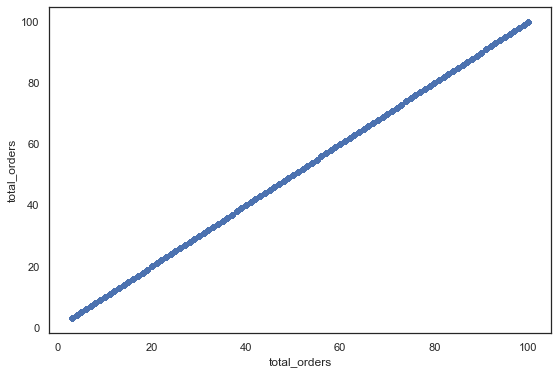

In [210]:
explore(user_summary, 'total_orders')

#### 2 total_products

Quantile analysis:
count    206209.000000
mean        164.004025
std         206.014923
min           3.000000
25%          44.000000
50%          90.000000
75%         196.000000
max        3725.000000
Name: total_products, dtype: float64



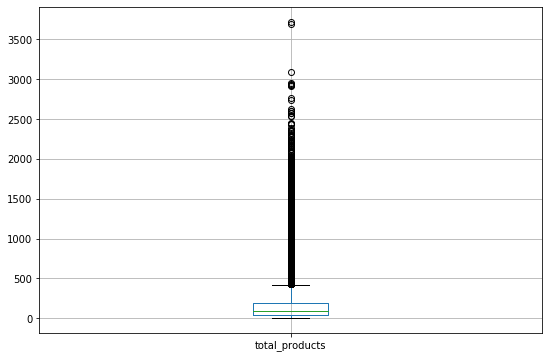

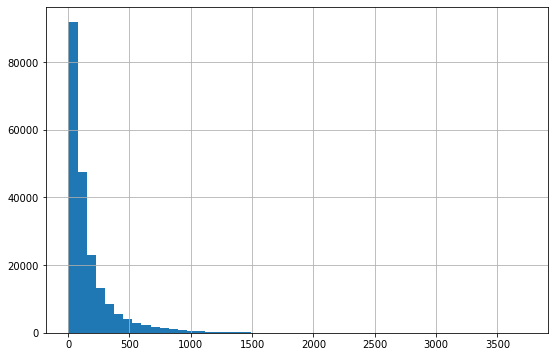

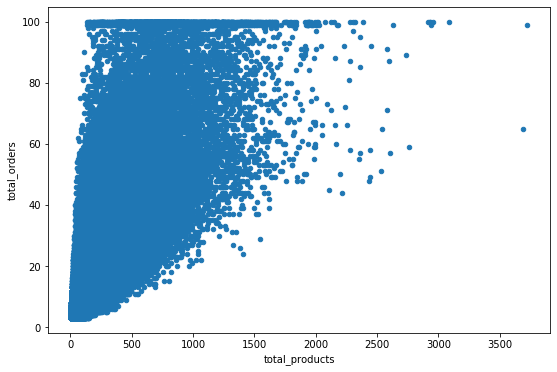

In [81]:
explore(user_summary, 'total_products')

#### 3 min_products

Quantile analysis:
count    206209.000000
mean          4.149993
std           3.812938
min           1.000000
25%           1.000000
50%           3.000000
75%           6.000000
max          50.000000
Name: min_products, dtype: float64



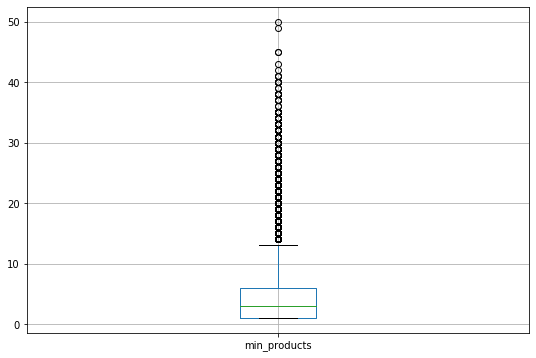

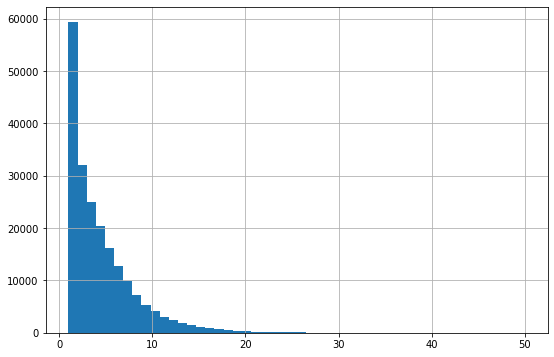

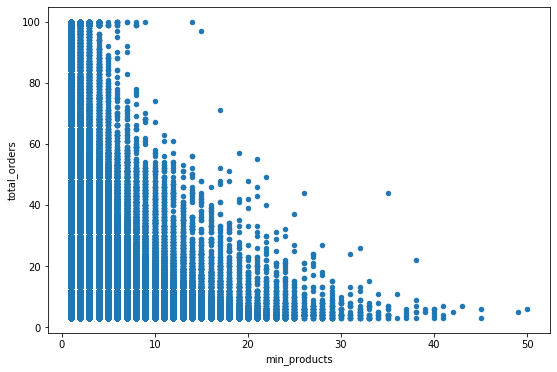

In [82]:
explore(user_summary, 'min_products')

#### 4 max_products

Quantile analysis:
count    206209.000000
mean         17.971805
std          10.230552
min           1.000000
25%          10.000000
50%          16.000000
75%          24.000000
max         145.000000
Name: max_products, dtype: float64



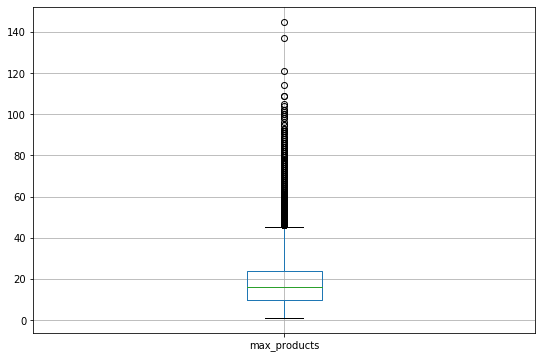

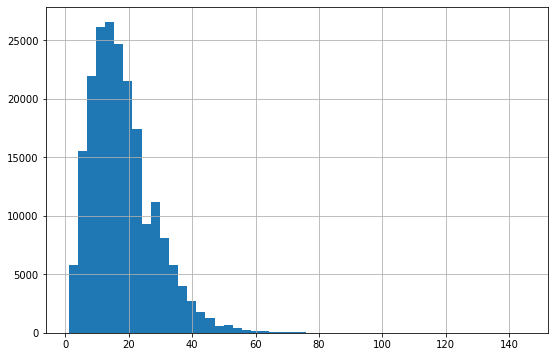

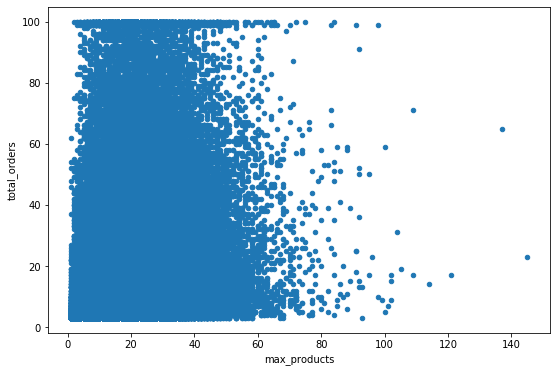

In [83]:
explore(user_summary, 'max_products')

#### 5 med_products

Quantile analysis:
count    206209.000000
mean          9.552197
std           5.986835
min           1.000000
25%           5.000000
50%           8.000000
75%          12.500000
max          66.000000
Name: med_products, dtype: float64



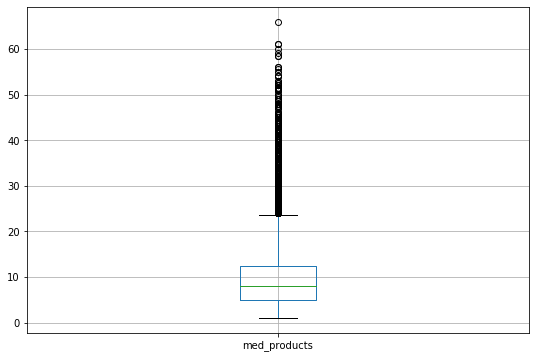

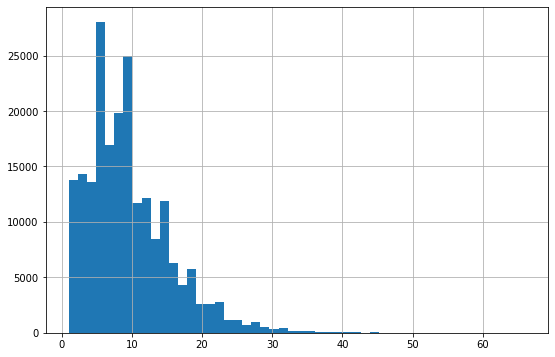

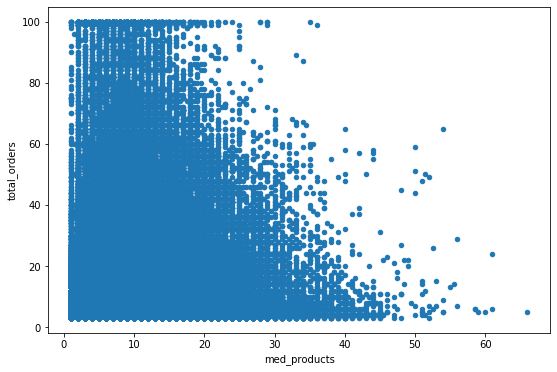

In [106]:
explore(user_summary, 'med_products')

#### 6 avg_products

Quantile analysis:
count    206209.000000
mean          9.984527
std           5.840846
min           1.000000
25%           5.777778
50%           9.000000
75%          13.000000
max          60.500000
Name: avg_products, dtype: float64



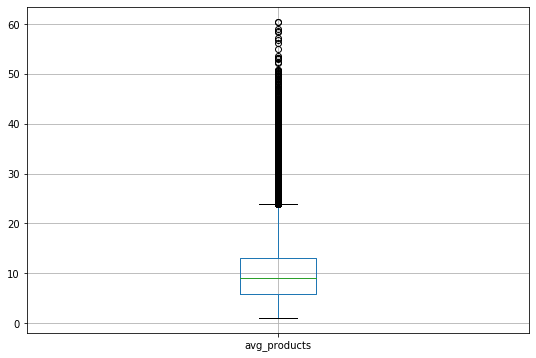

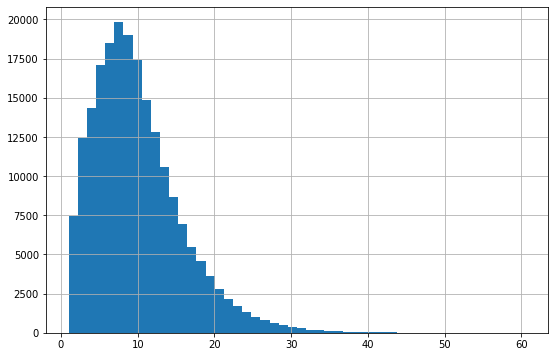

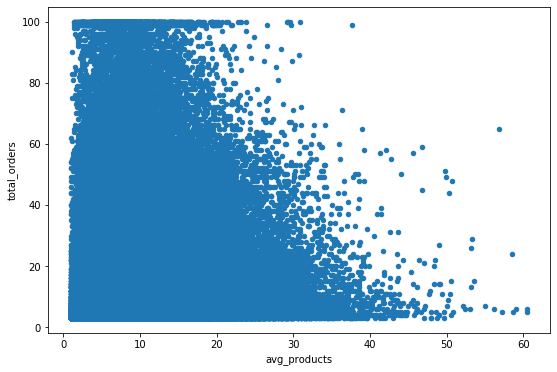

In [84]:
explore(user_summary, 'avg_products')

#### 7 std_products

Quantile analysis:
count    206209.000000
mean          4.325211
std           2.649550
min           0.000000
25%           2.428992
50%           3.845220
75%           5.667892
max          44.747439
Name: std_products, dtype: float64



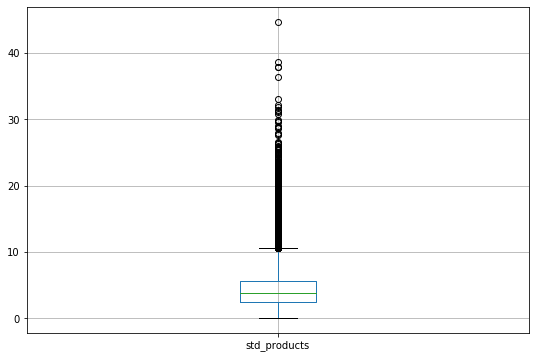

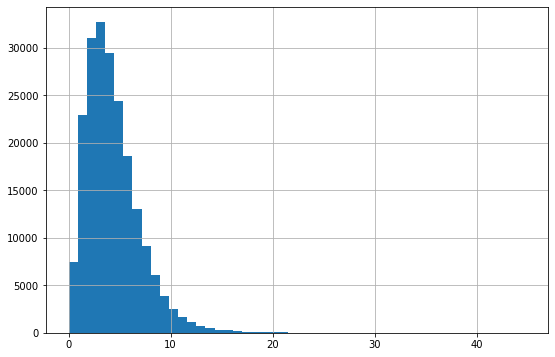

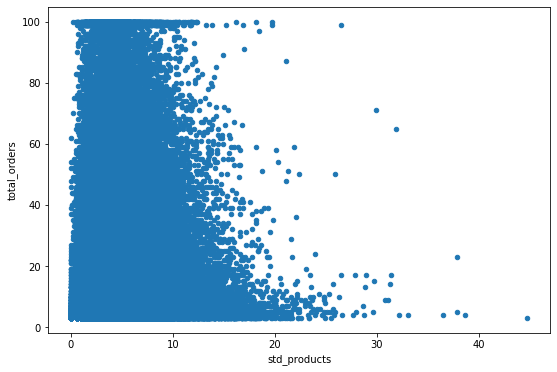

In [85]:
explore(user_summary, 'std_products')

#### 8 max_reordered

Quantile analysis:
count    206209.000000
mean          0.833443
std           0.244754
min           0.000000
25%           0.705882
50%           1.000000
75%           1.000000
max           1.000000
Name: max_reordered, dtype: float64



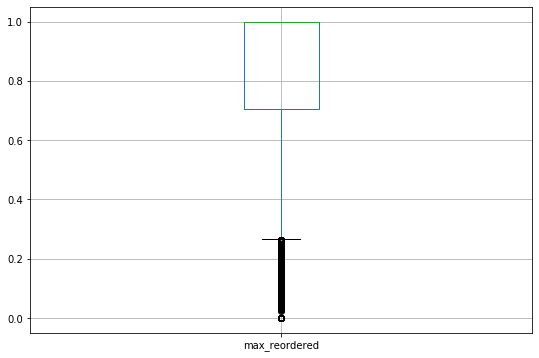

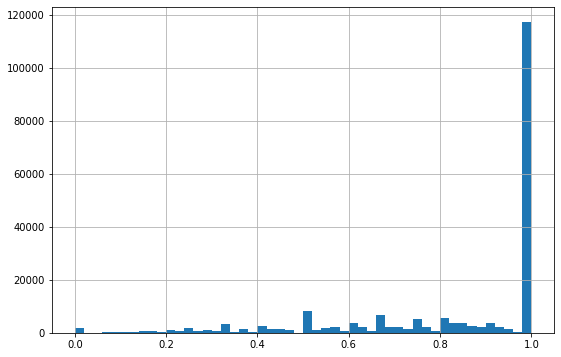

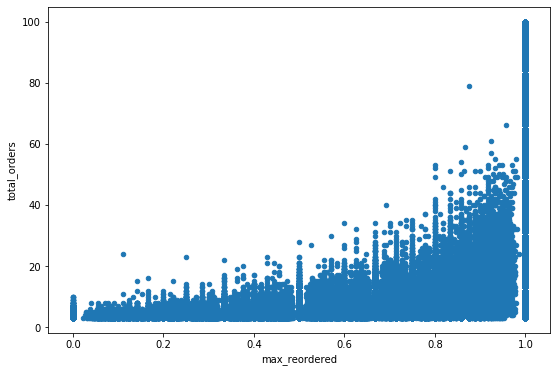

In [86]:
explore(user_summary, 'max_reordered')

#### 9 med_reordered

Quantile analysis:
count    206209.000000
mean          0.484092
std           0.272571
min           0.000000
25%           0.275000
50%           0.500000
75%           0.689655
max           1.000000
Name: med_reordered, dtype: float64



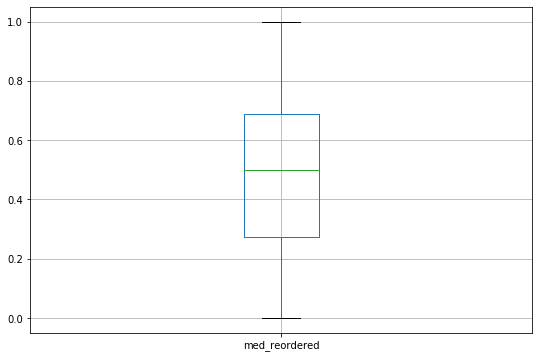

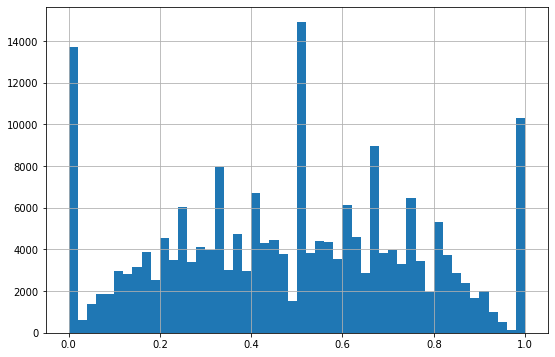

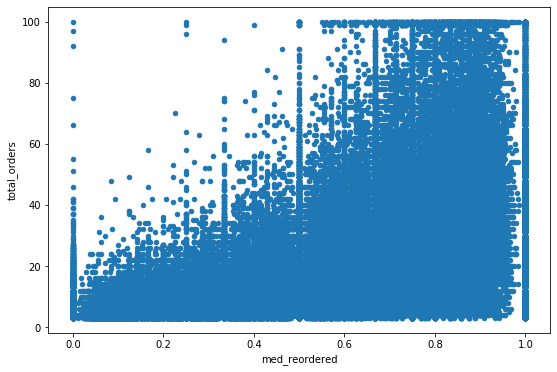

In [87]:
explore(user_summary, 'med_reordered')

#### 10 avg_reordered

Quantile analysis:
count    206209.000000
mean          0.469347
std           0.209077
min           0.000000
25%           0.313265
50%           0.475913
75%           0.631917
max           0.990000
Name: avg_reordered, dtype: float64



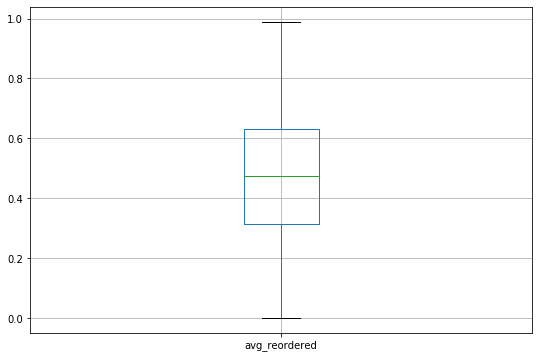

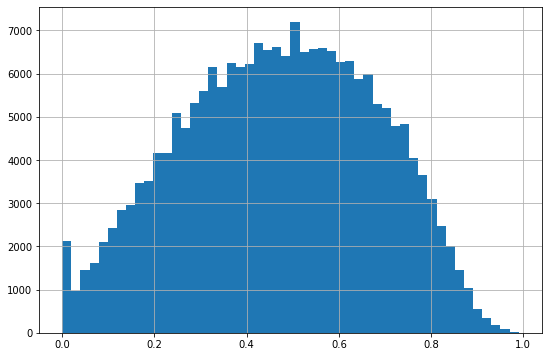

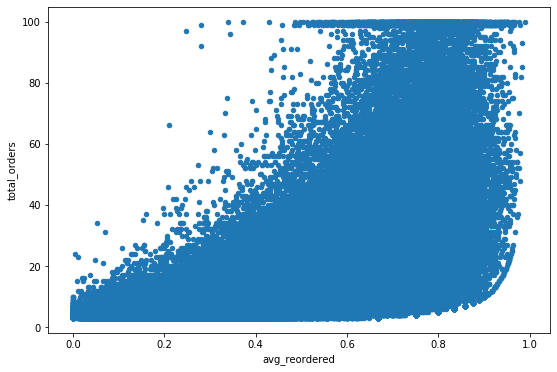

In [88]:
explore(user_summary, 'avg_reordered')

#### 11 std_reordered

Quantile analysis:
count    206209.000000
mean          0.286514
std           0.091503
min           0.000000
25%           0.233907
50%           0.283393
75%           0.340102
max           0.577350
Name: std_reordered, dtype: float64



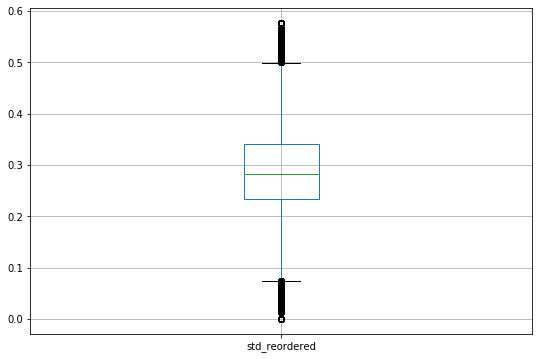

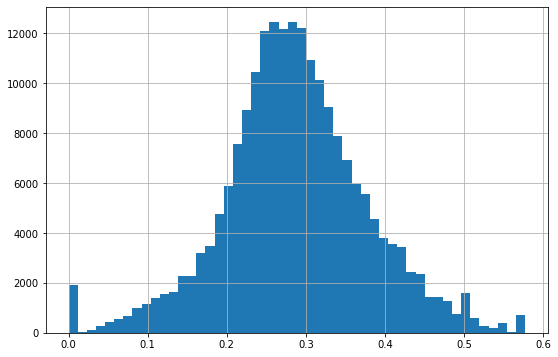

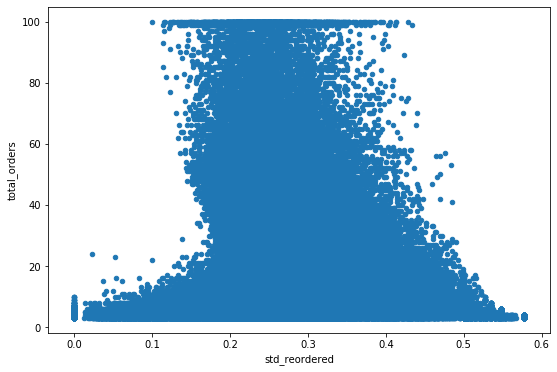

In [89]:
explore(user_summary, 'std_reordered')

#### 12 mode_day_of_week

In [ ]:
# explore(user_summary, 'mode_day_of_week')

#### 13 mode_hour_of_day

In [102]:
# explore(user_summary, 'mode_hour_of_day')

#### 14 total_days

Quantile analysis:
count    206209.000000
mean        153.926541
std         203.390046
min           2.000000
25%          36.000000
50%          80.000000
75%         184.000000
max        3636.000000
Name: total_days, dtype: float64



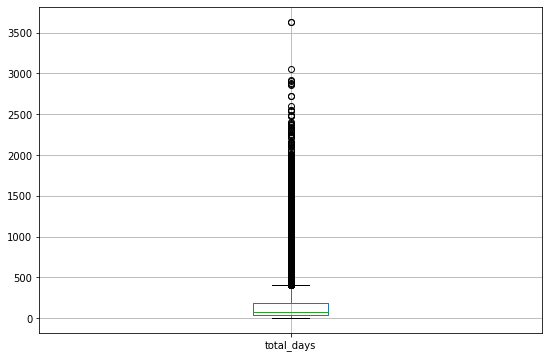

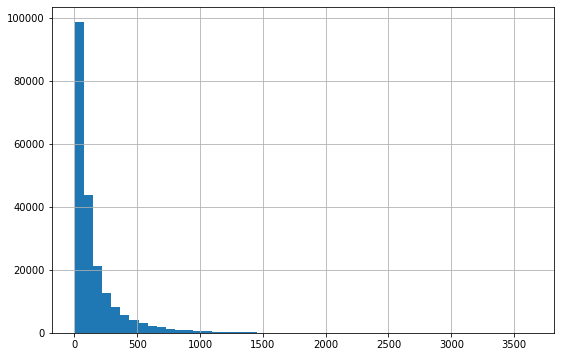

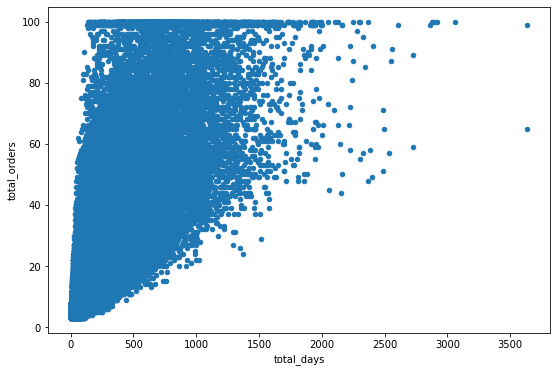

In [92]:
explore(user_summary, 'total_days')

#### 15 min_days

Quantile analysis:
count    206209.000000
mean          6.063601
std           7.123800
min           0.000000
25%           1.000000
50%           4.000000
75%           7.000000
max          30.000000
Name: min_days, dtype: float64



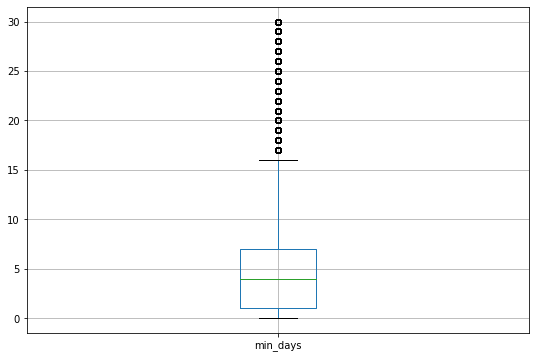

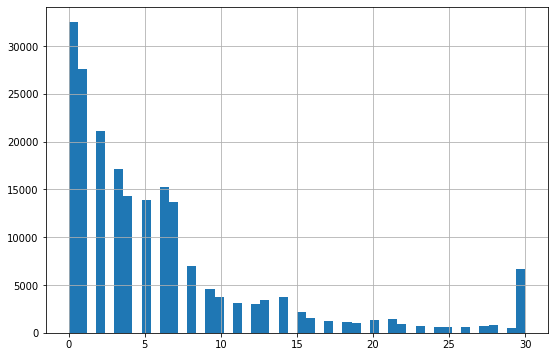

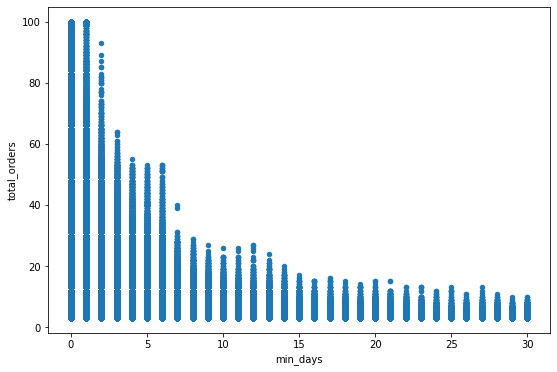

In [93]:
explore(user_summary, 'min_days')

#### 16 max_days

Quantile analysis:
count    206209.000000
mean         26.785228
std           6.236469
min           0.000000
25%          27.000000
50%          30.000000
75%          30.000000
max          30.000000
Name: max_days, dtype: float64



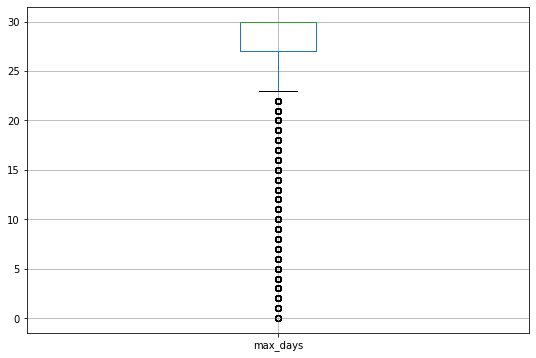

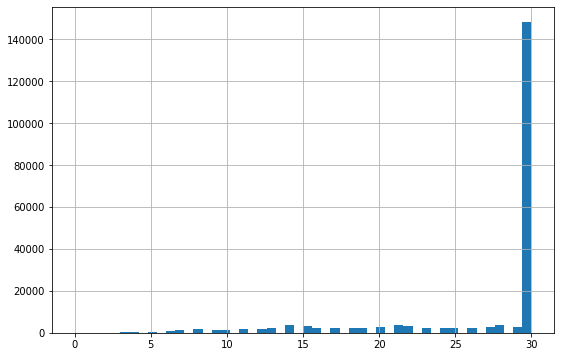

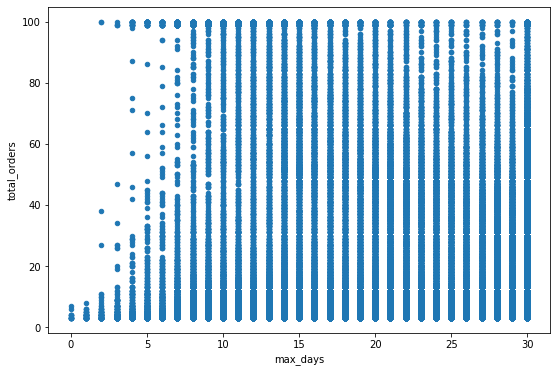

In [94]:
explore(user_summary, 'max_days')

#### 17 med_days

Quantile analysis:
count    206209.000000
mean         15.326572
std           9.097779
min           0.000000
25%           7.000000
50%          13.000000
75%          23.000000
max          30.000000
Name: med_days, dtype: float64



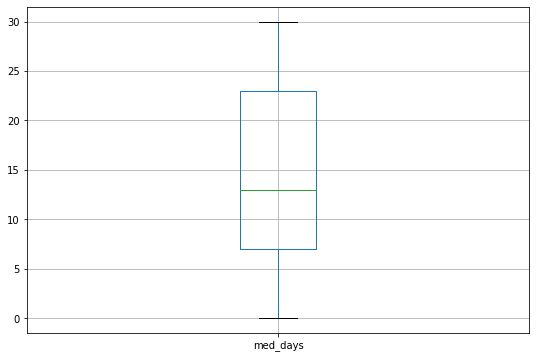

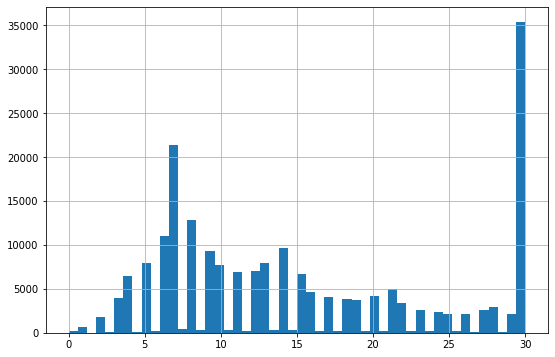

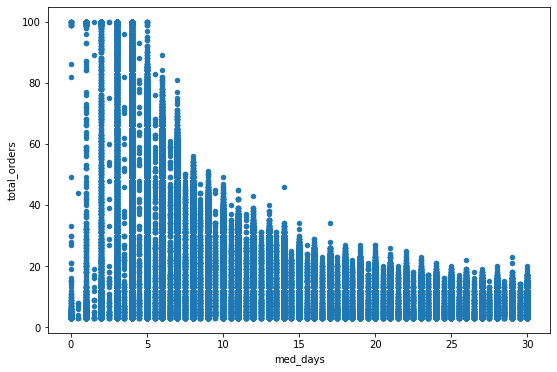

In [95]:
explore(user_summary, 'med_days')

#### 18 avg_days

Quantile analysis:
count    206209.000000
mean         15.631327
std           7.090661
min           0.000000
25%           9.809524
50%          15.000000
75%          20.916667
max          30.000000
Name: avg_days, dtype: float64



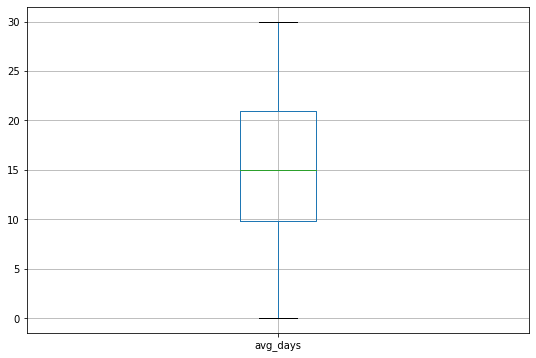

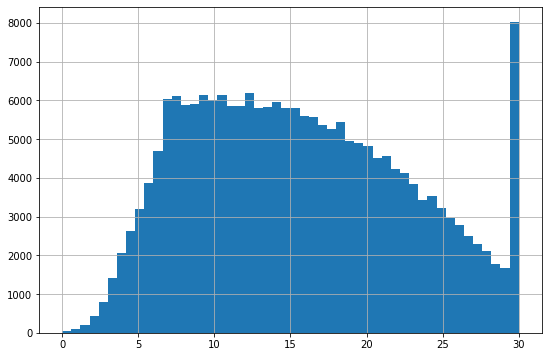

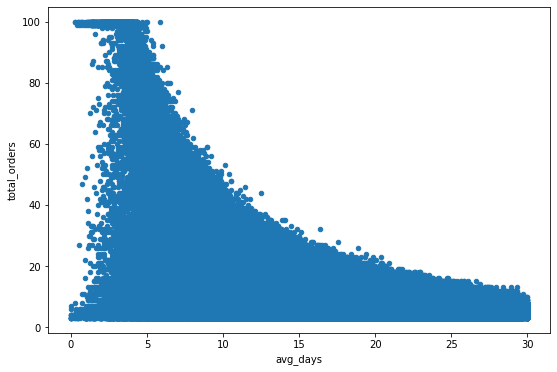

In [96]:
explore(user_summary, 'avg_days')

#### 19 std_days

Quantile analysis:
count    206209.000000
mean          6.868259
std           3.132251
min           0.000000
25%           4.664371
50%           7.292058
75%           9.174053
max          21.213203
Name: std_days, dtype: float64



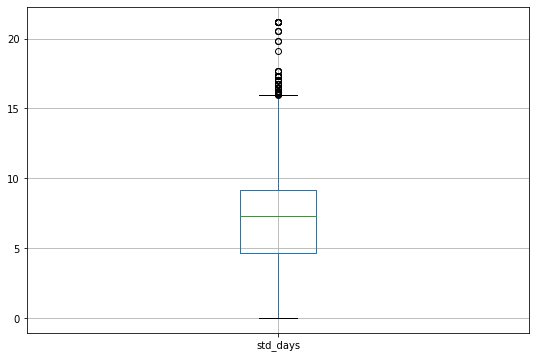

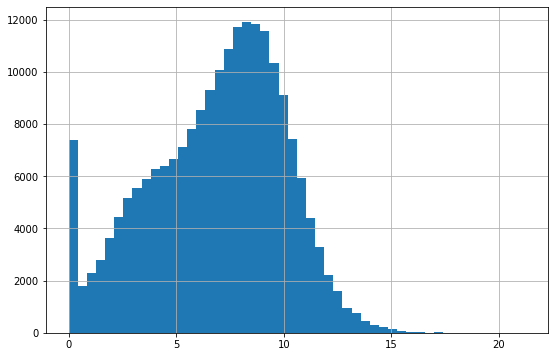

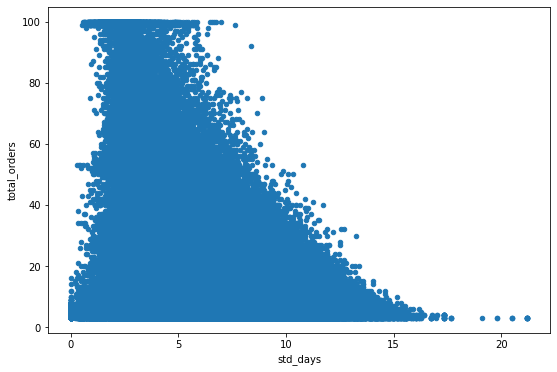

In [99]:
explore(user_summary, 'std_days')